In [30]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from prediction_pipeline.preprocessing import *
#from prediction_pipeline.build_sysmex_features import *
#from prediction_pipeline.training import *
#from sklearn.manifold import TSNE
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.linear_model import LinearRegression
#from matplotlib.patches import Patch
%load_ext cython
from bgen.reader import BgenFile
import subprocess
from scipy.stats import binom_test,mannwhitneyu, pearsonr
from sklearn.preprocessing import quantile_transform
from ggs import GGS
from sklearn.cross_decomposition import PLSRegression
from collections import defaultdict 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [2]:
#data_dir = "/Users/hippolyte/sysmex2pf/data"
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
training_data = "%s/training_exports" % data_dir
#FACS_cols = ["FSC","SSC","SFL","FSCW"]
FACS_cols = ["FSC","SSC","SFL"]
pheno_cols = ["ADP_FIB","CRP_FIB","TRAP_FIB","PAR1_FIB","PAR4_FIB","FIB"]
#pheno_cols = ["ADP","CRP","TRAP","PAR1","PAR4"]
covar_cols = ["MPV","PLT","PCT","PDW","IPF","Age","Sex"] 
EUR_path = "%s/genetic_score/EUR" % export_folder

In this notebook, I evaluated the prediction power obtained without using a PCA to reduce the dimensionality of the point cloud. It's not as good as with PCA (R^2 = 0.08 VS 0.11)

# Load tables

In [4]:
sys_sct = pd.read_hdf("%s/sys_sct_filtered.hdf" % training_data)

In [7]:
pheno_df = pd.read_hdf("%s/pheno_df.hdf" % training_data, key="pheno_df")
covar = pd.read_hdf("%s/covar.hdf" % training_data, key="covar")

# Build features

In [114]:
def median_SSC_low_SFL(d):
    mean_SFL = d.SFL.mean()
    std_SFL = d.SFL.std()
    return np.std(d.loc[d.SFL < (mean_SFL - .5*std_SFL),"SSC"])
def median_FSC_low_SSC(d):
    mean_SSC = d.SSC.mean()
    std_SSC = d.SSC.std()
    return np.std(d.loc[d.SSC < (mean_SSC - .5*std_SSC),"FSC"])
def median_SFL_low_FSC(d):
    mean_FSC = d.FSC.mean()
    std_FSC = d.FSC.std()
    return np.std(d.loc[d.FSC < (mean_FSC - .5*std_FSC),"SFL"])

In [ ]:
g = sys_sct.groupby("ID")
fsc_low = g["FSC"].quantile(0.1)
fsc_high = g["FSC"].quantile(0.9)
fsc_iqr = g["FSC"].quantile(0.75) - g["FSC"].quantile(0.25)
fsc_median = g["FSC"].quantile(0.5)
fsc_mean = g["FSC"].mean()
fsc_std = g["FSC"].std()

ssc_low = g["SSC"].quantile(0.1)
ssc_high = g["SSC"].quantile(0.9)
ssc_iqr = g["SSC"].quantile(0.75) - g["SSC"].quantile(0.25)
ssc_median = g["SSC"].quantile(0.5)
ssc_mean = g["SSC"].mean()
ssc_std = g["SSC"].std()

sfl_low = g["SFL"].quantile(0.1)
sfl_high = g["SFL"].quantile(0.9)
sfl_iqr = g["SFL"].quantile(0.75) - g["SFL"].quantile(0.25)
sfl_median = g["SFL"].quantile(0.5)
sfl_mean = g["SFL"].mean()
sfl_std = g["SFL"].std()

log_std_fsc_ssc = np.log10(fsc_std/ssc_std)
log_std_sfl_ssc = np.log10(sfl_std/ssc_std)

#ratio_high_fsc_ssc = np.log10((fsc_high - fsc_median)/(ssc_high - ssc_median))
#ratio_high_fsc_sfl = np.log10((fsc_high - fsc_median)/(sfl_high - sfl_median))
ratio_low_fsc_ssc = np.log10((fsc_low - fsc_median)/(ssc_low - ssc_median))
ratio_low_fsc_sfl = np.log10((fsc_low - fsc_median)/(sfl_low - sfl_median))

cross_1 = g.apply(median_SSC_low_SFL)
cross_2 = g.apply(median_FSC_low_SSC)
cross_3 = g.apply(median_SFL_low_FSC)

In [116]:
features = pd.DataFrame.from_dict({"fsc_low"   :fsc_low,
                            "fsc_high"  :fsc_high,
                            "fsc_iqr"   :fsc_iqr,
                            "fsc_median":fsc_median,
                            "fsc_mean"  :fsc_mean,
                            "fsc_std"   :fsc_std,
                            "ssc_low"   :ssc_low,
                            "ssc_high"  :ssc_high,
                            "ssc_iqr"   :ssc_iqr,
                            "ssc_median":ssc_median,
                            "ssc_mean"  :ssc_mean,
                            "ssc_std"   :ssc_std,
                            "sfl_low"   :sfl_low,
                            "sfl_high"  :sfl_high,
                            "sfl_iqr"   :sfl_iqr,
                            "sfl_median":sfl_median,
                            "sfl_mean"  :sfl_mean,
                            "sfl_std"   :sfl_std,
                            "log_fsc_ssc":log_std_fsc_ssc,
                            "log_sfl_ssc":log_std_sfl_ssc,
                            #"ratio_high_fsc_ssc":ratio_high_fsc_ssc,
                            #"ratio_high_fsc_sfl":ratio_high_fsc_sfl,
                            "cross_1"   :cross_1,
                            "cross_2"   :cross_2,
                            "cross_3"   :cross_3,
                            "ratio_low_fsc_ssc":ratio_low_fsc_ssc,
                            "ratio_low_fsc_sfl":ratio_low_fsc_sfl})

In [117]:
features -= features.mean(axis=0)
features /= features.std(axis=0)

In [118]:
X_train = pd.merge(covar,pheno_df,left_index=True,right_index=True,how="inner")
X_train = pd.merge(X_train,features,left_index=True,right_index=True,how="inner")

In [119]:
for f in features.columns:
    corr = False
    for c in covar_cols:
        r, p = pearsonr(X_train[f],X_train[c])
        if p < 1e-2:
            print(f,c,r,p)
            corr = True
    if not corr:
        print(f)

fsc_low MPV 0.7736408683301446 4.1142068065706193e-106
fsc_low PLT -0.3066588178868405 6.145490564249703e-13
fsc_low PDW 0.7296693073823343 1.036683660541424e-88
fsc_low IPF 0.5885758634173014 1.9318041235827665e-50
fsc_low Age -0.16152807516920178 0.00019625249370545876
fsc_high MPV 0.9299953702982624 2.3841826749015886e-230
fsc_high PLT -0.5359321692345093 1.6248604406763575e-40
fsc_high PCT -0.14522666820171373 0.0008266319524599193
fsc_high PDW 0.9065973982159278 7.4349470747074515e-199
fsc_high IPF 0.8810580567476805 7.987936420708478e-173
fsc_iqr MPV 0.8281019111835711 4.53888146236136e-134
fsc_iqr PLT -0.5604112905440787 6.551466827004294e-45
fsc_iqr PCT -0.24827534905944953 7.6187097905956e-09
fsc_iqr PDW 0.8241568197349349 9.989112895023193e-132
fsc_iqr IPF 0.8359861480315364 6.179544107549365e-139
fsc_median MPV 0.9075727034414625 5.400702211338908e-200
fsc_median PLT -0.47236811088112574 1.204348382703755e-30
fsc_median PDW 0.8824777154450122 4.157757758288745e-174
fsc_media

In [120]:
lm = LinearRegression().fit(X_train[covar_cols],X_train[features.columns])
X_train[features.columns] -= lm.predict(X_train[covar_cols])

In [121]:
N_PLS_COMPS = 1

In [122]:
rho_cov = defaultdict(lambda: [])
rho_all = defaultdict(lambda: [])
y_pred_test = {}
y_test = {}
r2_cov = defaultdict(lambda: [])
r2_all = defaultdict(lambda: [])
r2_res = defaultdict(lambda: [])
for c in pheno_cols:
    skf = RepeatedStratifiedKFold(n_splits=4,n_repeats=100)
    y = X_train[c]
    cond = ~y.isnull()
    X = X_train.loc[cond,features.columns]
    C = X_train.loc[cond,covar_cols]
    y = y.loc[cond]
    
    y_split = pd.cut(y,3,labels=False)
    
    for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(y_split)), y_split)):
        #print(len(train_index),len(test_index))
        pls = LinearRegression()
        pls.fit(C.iloc[train_index],y.iloc[train_index])
        y_cov = np.reshape(pls.predict(C),(-1,1))
        
        residuals = y-y_cov[:,0]
        pls_res = PLSRegression(n_components=N_PLS_COMPS)
        pls_res.fit(X.iloc[train_index],residuals.iloc[train_index])
        y_res = pls_res.predict(X)
        y_pred = y_cov + y_res
        
        pearson_all = pearsonr(y.iloc[test_index],y_pred[test_index,0])[0]
        pearson_cov = pearsonr(y.iloc[test_index],y_cov[test_index,0])[0]
        
        rho_cov[c].append(pearson_cov)
        rho_all[c].append(pearson_all)
        r2_all[c].append(r2_score(y.iloc[test_index],y_pred[test_index,0]))
        r2_cov[c].append(r2_score(y.iloc[test_index],y_cov[test_index,0]))
        r2_res[c].append(r2_score(residuals.iloc[test_index],y_res[test_index,0]))
        
        if i == 0:
            
            y_pred_test[c] = y_pred[test_index,0]
            y_test[c] = y.iloc[test_index]
        

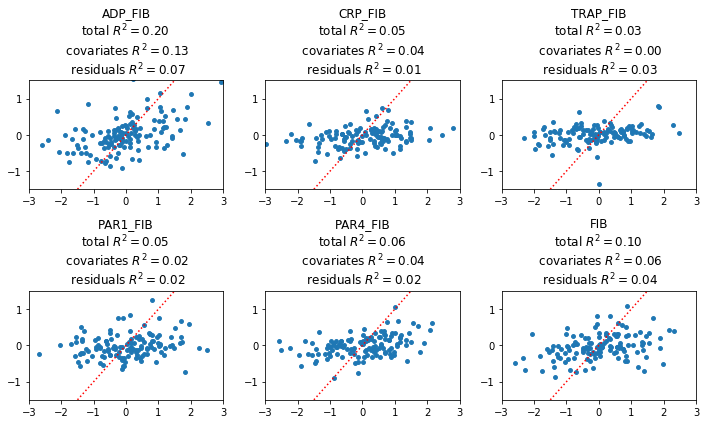

In [123]:
from sklearn.metrics import r2_score
fig = plt.figure(figsize=(10,6))
for i, c in enumerate(pheno_cols):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(y_test[c],y_pred_test[c],s=15)
    ax.set_ylim((-1.5,1.5))
    ax.set_xlim((-3,3))
    ax.plot([-1.5,1.5],[-1.5,1.5],c="red",ls=":")
    #R2 = r2_score(y_test[c],y_pred_test[c])
    R2 = np.median(r2_all[c])
    R2_res = np.median(r2_res[c])
    R2_cov = np.median(r2_cov[c])
    ax.set_title("%s\ntotal $R^2=%.2f$ \n covariates $R^2 = %.2f $ \n residuals $ R^2=%.2f $" % (c,R2,R2_cov,R2_res))
plt.tight_layout()
plt.savefig("%s/predictions_test.pdf" % export_folder)